
### References 
[Slides](https://davidrosenberg.github.io/mlcourse/Archive/2017Fall/Lectures/11a.gradient-boosting.pdf)

# Gradient Boosting from Scratch

## Introduction 
Gradient Boosting is one of the most used ensemble machine learning techniques, for both regression and classification. This model uses an sequence of weak Decision Trees to build a strong learner. 
In this post we will be building a gradient boosting model from scratch and visualizing it.



## Algorithm Explained
We have a dataset of features $x_i$ and values $y_i$
$$D = {(x_i,y_i), i \in 1,...,N}$$
We want to compute $F(x) = \mathbb{E}(y|x=x)$

At every step we want F_m(x) a better approximation of y|x=x 
$$F_m(x)= F_{m-1}(x) + h_{m-1}(x)$$
ie: 
We compute h_{m-1}(x) from the residuals:
$$y_i = F_{m-1}(x_i) + r_i $$
$$D_{res} = {(x_i,r_i), i \in 1,...,N}$$
$h_{m-1}$ is a good approximation of $y - F_{m-1}$. 


### Second interpretation
$$D = {(x_i,y_i), i \in 1,...,N}$$
We want to compute $F(x) = \mathbb{E}(y|x=x)$.

At every step we want F_m(x) a better approximation of y given x.

We want to minimize the loss function $L_m(x)=(y-Fm(x))^2$.

Therefore we take a step in the direction of steepest descent for the loss function:
$$ g_m(x) = -\frac{\partial{L_m}}{\partial{F_m(x)}}(y,F_m(x)) = y-F_m(x)$$

Wow, this gradient is exactly equal to the residual for x at step m!

Thus we can approximate this gradient function $g_m$ with a weak regression tree $h_m$, trained over the residuals:

$$D_{res} = {(x_i,  y_i - F_{m-1}(x_i)), i \in 1,...,N}$$


## Pseudo-Code
1.  $$F_0(x) = arg min_{\gamma} L(\gamma,Y) = cst, \gamma \in \mathbb{R} $$ 
2.  Compute residuals:
$$D_{res} = {(x_i,r_i), i \in 1,...,N}$$
3. Fit a regression tree, to approximate y-F_m-1
We have, $$R(x_i) = r_i := y_i - F_{m-1}(x_i)$$
We suppose $$ R(x_i) = \hat{R}(x_i) + \epsilon_i $$
where the $\epsilon_i$ and $\hat{R}$ is a weak learner model. 
4. Update the model with a given step size
$$F_m = F_{m-1} + \alpha \hat{R} $$


In [250]:
import numpy as np
import sklearn.datasets as ds
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import tree
from itertools import product,islice
import seaborn as sns 


In [299]:
moonDS = ds.make_moons(200, noise = 0.15, random_state=16)
moon = moonDS[0]
color = moonDS[1]*2-1
print(color[:10])

df =pd.DataFrame(moon, columns = ['x','y'])
df['z'] = color
df['f0'] =df.y.mean()
df['r0'] = df['z'] - df['f0']
df.head()



[ 1 -1  1 -1  1  1 -1 -1 -1 -1]


x         y  z        f0        r0
0  0.985425 -0.526577  1  0.232734  0.767266
1  0.888722  0.004503 -1  0.232734 -1.232734
2  1.763366 -0.118523  1  0.232734  0.767266
3 -0.280279  0.804625 -1  0.232734 -1.232734
4  0.330227  0.407421  1  0.232734  0.767266

[DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1)]

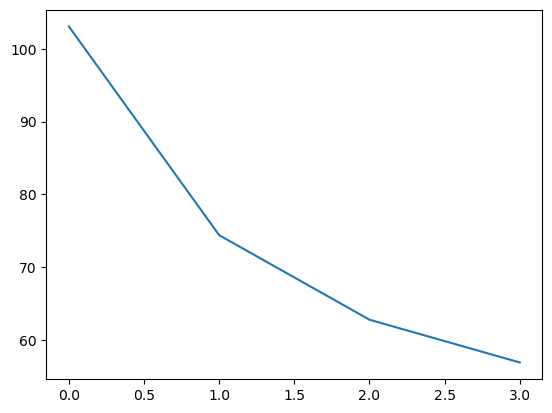

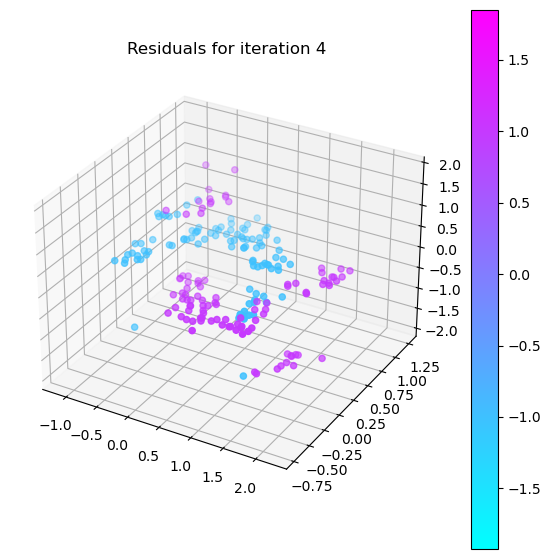

In [303]:
def makeiteration(i:int, plot=True):
    """Takes the dataframe ith f_i and r_i and approximated r_i from the features, then computes f_i+1 and r_i+1"""
    clf = tree.DecisionTreeRegressor(max_depth=1)
    clf.fit(X=df[['x','y']].values, y = df[f'r{i-1}'])
    df[f'r{i-1}hat'] = clf.predict(df[['x','y']].values)

    #find best eta
    etas = np.linspace(0.01,0.9,20)
    dfetas = pd.DataFrame()
    dfetas['etas'] = etas
    rmse_mat = df.z.values - df[f'f{i-1}'].values - etas.reshape((20,1))*df[f'r{i-1}hat'].values**2 #Shape (20,200)
    dfetas['rmse'] = (rmse_mat.sum(axis =1))
    
    eta = 0.9
    grad = - (df.z - df[f'f{i-1}'] - eta*df[f'r{i-1}hat']) @ (df[f'r{i-1}hat'])
    df[f'f{i}'] = df[f'f{i-1}'] + eta*df[f'r{i-1}hat']
    # plt.plot(dfetas.etas, dfetas.rmse)
    # plt.show()

    #add to f1 
    df[f'r{i}'] = df['z'] - df[f'f{i}']
    rmse = (df[f'r{i}']**2).sum()

    if plot:
        fig = plt.figure(figsize = (7,5))
        norm = mpl.colors.Normalize(vmin=df[f'r{i-1}hat'].min(), vmax=df[f'r{i-1}hat'].max())
        plt.scatter(df['x'], df['y'], c =  df[f'r{i-1}hat'], cmap = 'cool')
        fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='cool'), ax=plt.gca())
        plt.title(f'Iteration {i} - Residual {i-1} estimation')
        plt.show()
    return rmse, clf

def plot_residuals(i):
    resid = f'r{i}'
    cmap = mpl.cm.cool
    norm = mpl.colors.Normalize(vmin=df[f'r{i}'].min(), vmax=df[f'r{i}'].max())
    fig = plt.figure(figsize=(7, 7))
    ax = plt.axes(projection = '3d')
    ax.scatter3D(df.loc[df.z==1,'x'], df.loc[df.z==1,'y'], df.loc[df.z==1, resid], c = df.loc[df.z==1, 'z'], marker = 'o', cmap = 'cool', norm = norm )
    ax.scatter3D(df.loc[df.z==-1,'x'], df.loc[df.z==-1,'y'], df.loc[df.z==-1, resid], c = df.loc[df.z==-1, 'z'], marker = 'o', cmap = 'cool', norm = norm )
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    ax.set(title=f'Residuals for iteration {i}')

rmses = []
clfs = []
for k in range(1,5):
    rmsek,clfk = makeiteration(k, plot=False)
    rmses.append(rmsek)
    clfs.append(clfk)
plt.plot(rmses)

plot_residuals(4)
clfs

x         y  z        f0        r0     r0hat        f1        r1
0  0.985425 -0.526577  1  0.232734  0.767266  0.710928  0.872569  0.127431
1  0.888722  0.004503 -1  0.232734 -1.232734 -0.752114 -0.444168 -0.555832
2  1.763366 -0.118523  1  0.232734  0.767266  0.710928  0.872569  0.127431
3 -0.280279  0.804625 -1  0.232734 -1.232734 -0.752114 -0.444168 -0.555832
4  0.330227  0.407421  1  0.232734  0.767266 -0.752114 -0.444168  1.444168

[ 1 -1]


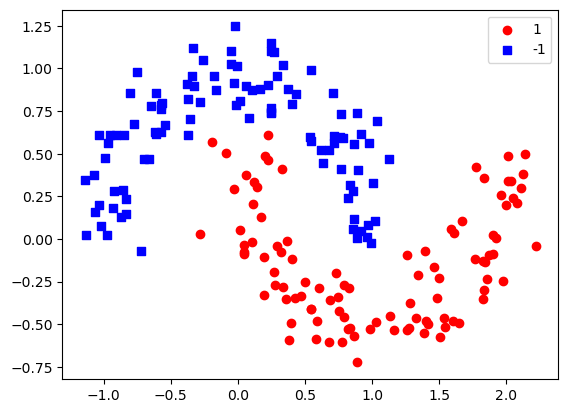

In [255]:
# plt.scatter(moon[:,0], moon[:,1], c = color, )
# plt.legend()
#you need to do two different scatters for the two classes
markers = ['o','s']
colors = ['r','b']
print(df.z.unique())
for i,cl in enumerate(df.z.unique()):
    plt.scatter(moon[df.z==cl,0],moon[df.z==cl,1], color = colors[i], marker= markers[i], label = cl)
plt.legend()



In [256]:
df.head()

x         y  z        f0        r0
0  0.985425 -0.526577  1  0.232734  0.767266
1  0.888722  0.004503 -1  0.232734 -1.232734
2  1.763366 -0.118523  1  0.232734  0.767266
3 -0.280279  0.804625 -1  0.232734 -1.232734
4  0.330227  0.407421  1  0.232734  0.767266

rmse 2: 129.1903970835797
rmse 3: 90.37431554674588
rmse 4: 72.54818710908914
rmse 5: 61.19287054124929
rmse 6: 57.06457747103342
rmse 7: 53.88028022540324
rmse 8: 50.92886524522196
rmse 9: 48.69133564206443
rmse 10: 46.88122175807453


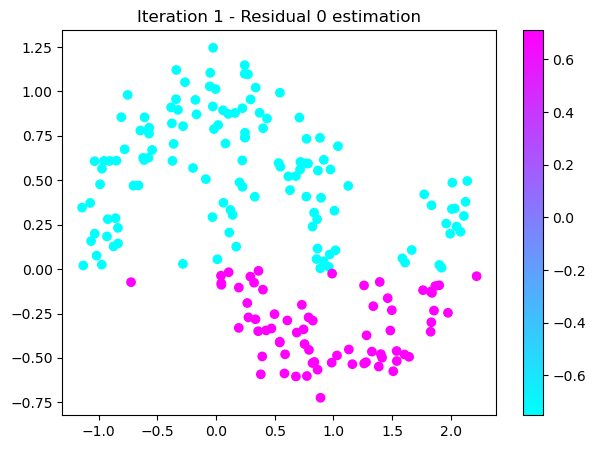

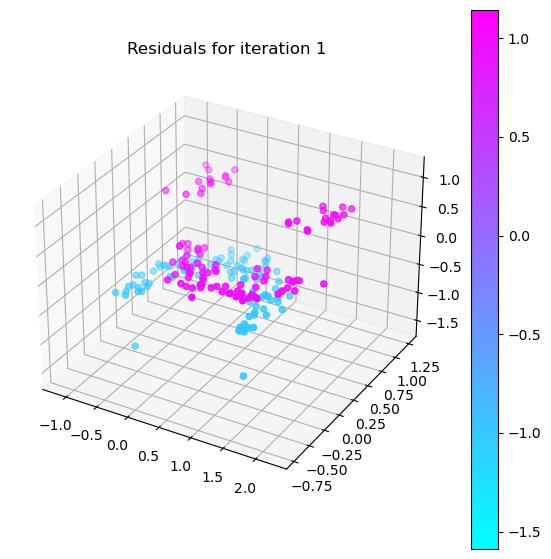

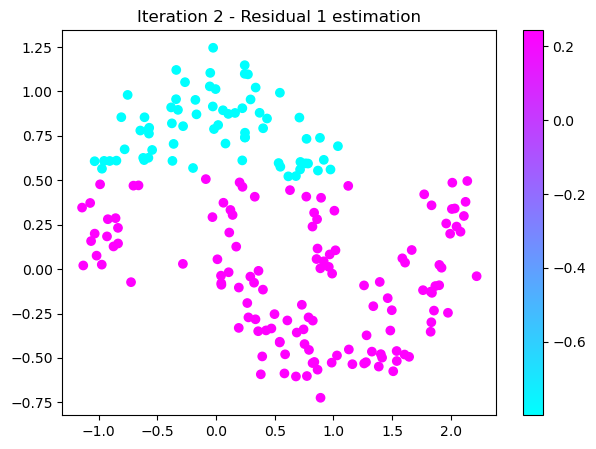

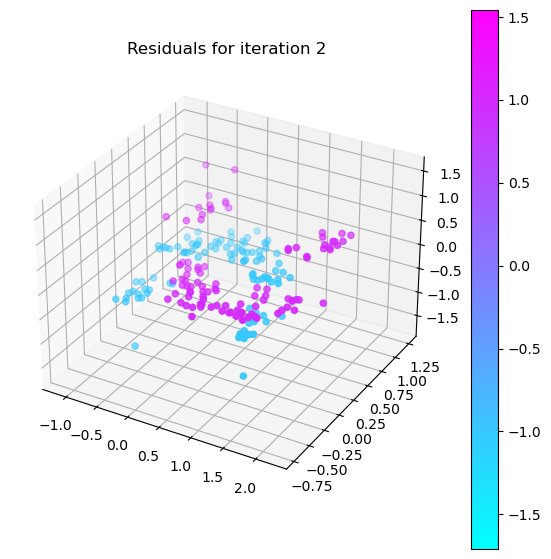

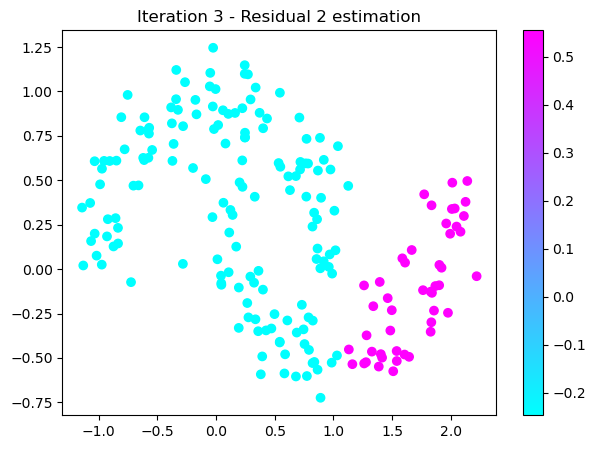

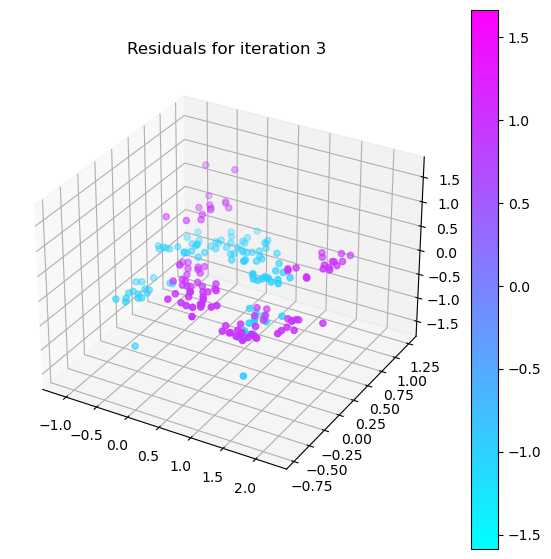

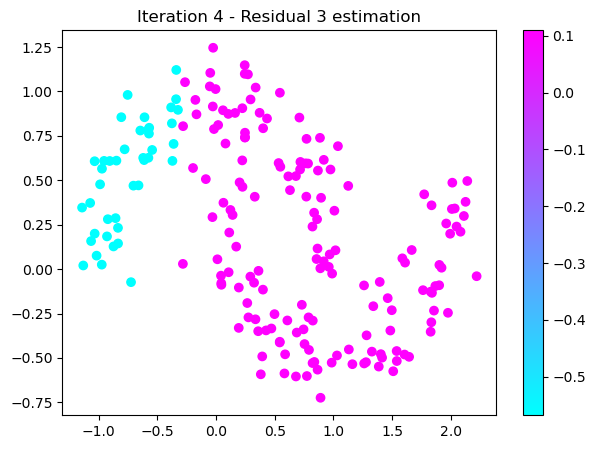

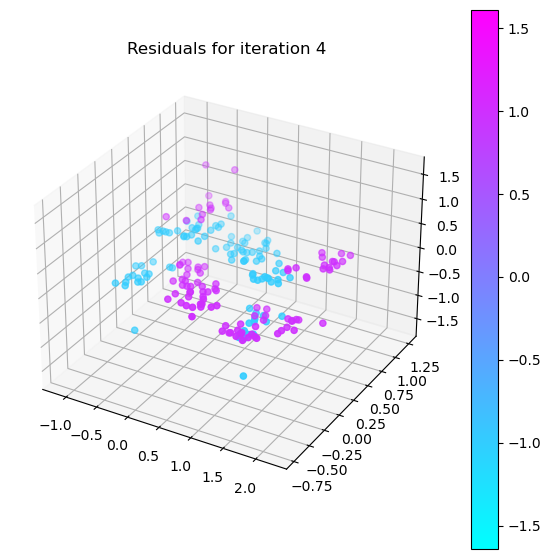

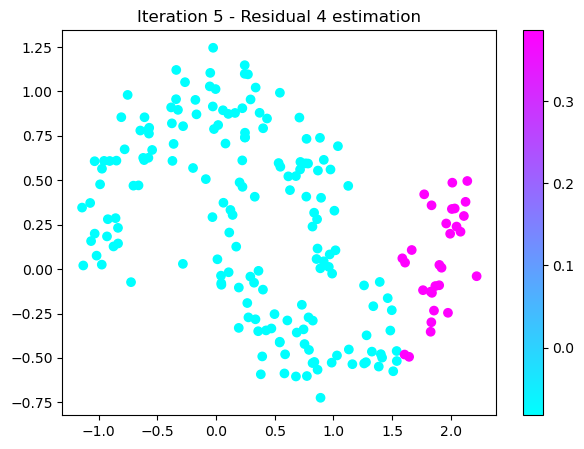

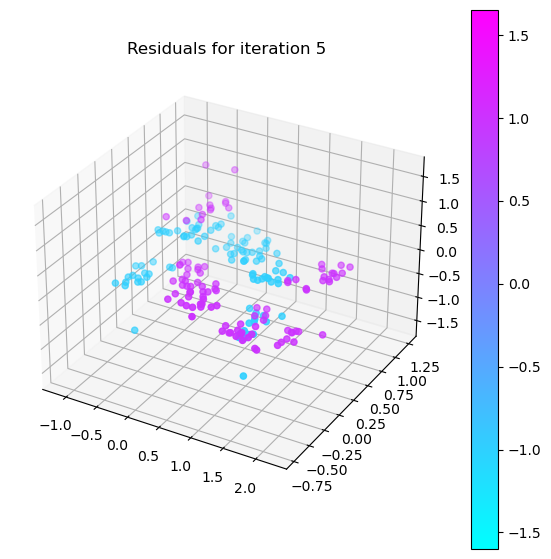

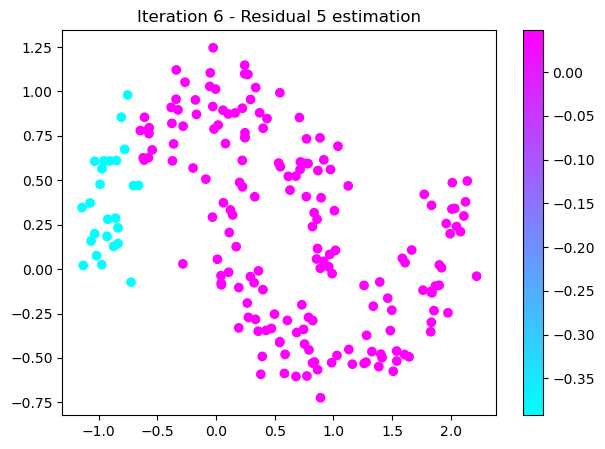

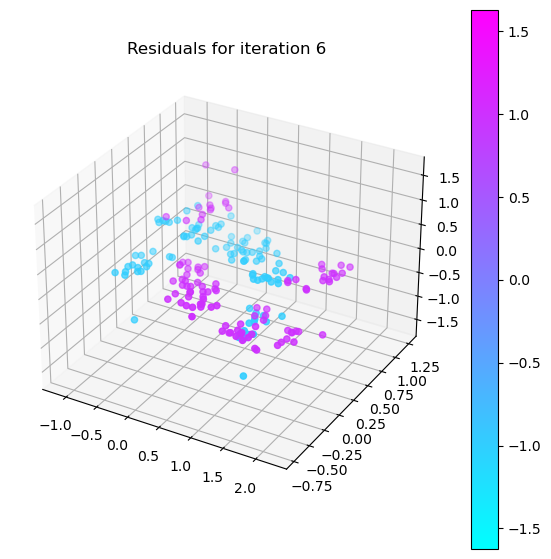

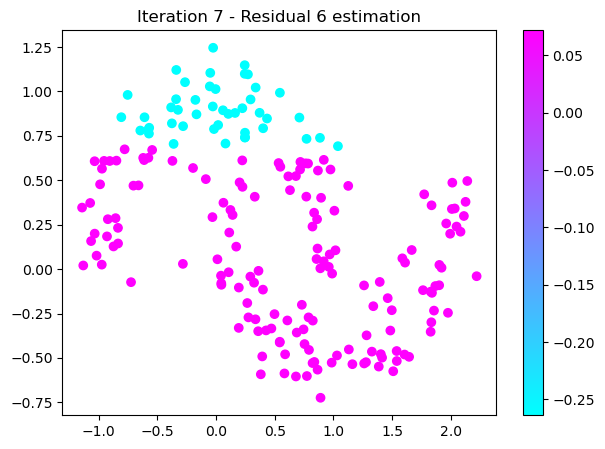

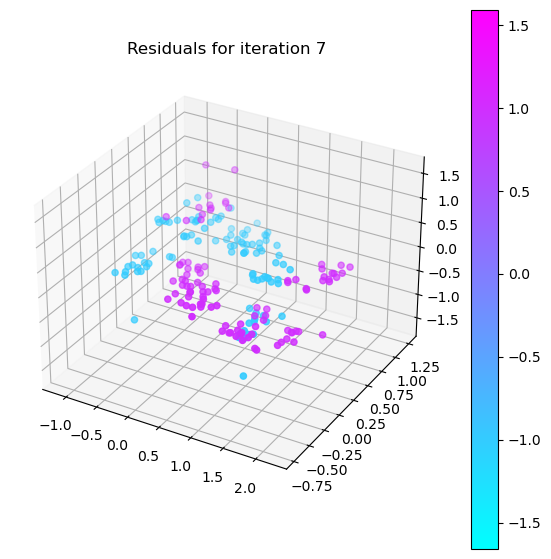

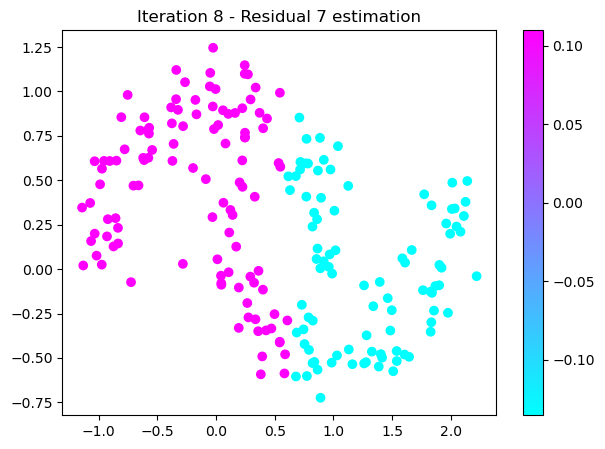

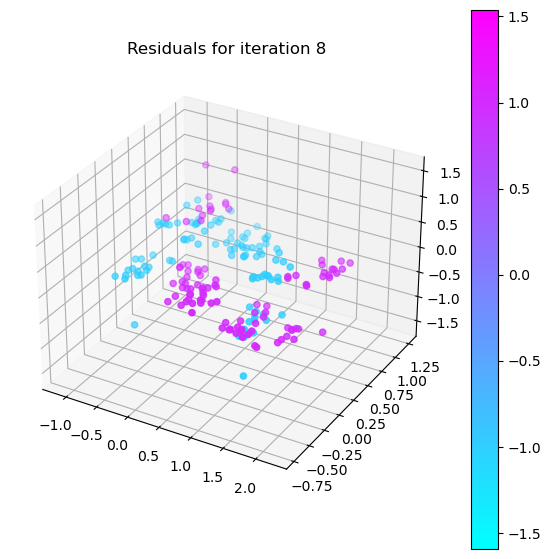

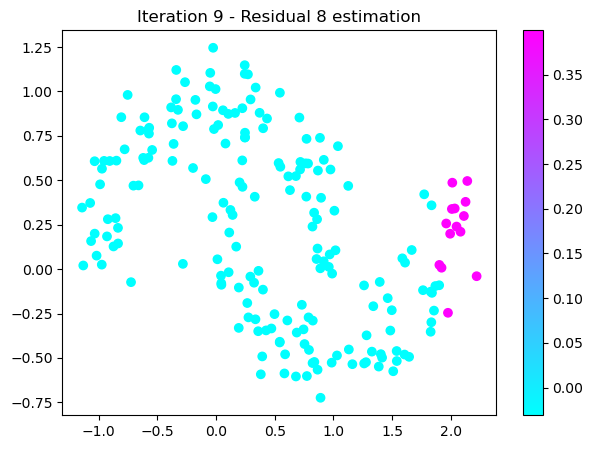

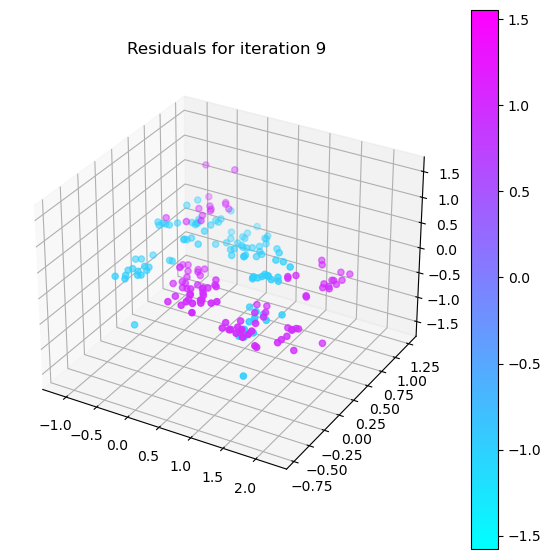

In [261]:
for k in range(1,10):
    makeiteration(k)
    plot_residuals(k)

In [262]:
df.head()

x         y  z        f0        r0     r0hat        f1        r1  \
0  0.985425 -0.526577  1  0.232734  0.767266  0.710928  0.588198  0.411802   
1  0.888722  0.004503 -1  0.232734 -1.232734 -0.752114 -0.143323 -0.856677   
2  1.763366 -0.118523  1  0.232734  0.767266  0.710928  0.588198  0.411802   
3 -0.280279  0.804625 -1  0.232734 -1.232734 -0.752114 -0.143323 -0.856677   
4  0.330227  0.407421  1  0.232734  0.767266 -0.752114 -0.143323  1.143323   

      r1hat        f2  ...       r16    r16hat       f17       r17    r17hat  \
0  0.243033  0.709714  ...  0.316098 -0.090481  0.638661  0.361339  0.027641   
1  0.243033 -0.021807  ... -0.737823 -0.090481 -0.307417 -0.692583  0.027641   
2  0.243033  0.709714  ... -0.181574 -0.090481  1.136333 -0.136333  0.027641   
3 -0.798706 -0.542676  ... -0.240769  0.060315 -0.729073 -0.270927  0.027641   
4  0.243033 -0.021807  ...  0.957675  0.060315  0.072482  0.927518  0.027641   

        f18       r18    r18hat       f19       r19  
0  0.652482  0.347518  0.035539  0.670251  0.329749  
1 -0.293596 -0.706404  0.035539 -0.275827 -0.724173  
2  1.150154 -0.150154  0.035539  1.167924 -0.167924  
3 -0.715253 -0.284747 -0.142160 -0.786333 -0.213667  
4  0.086303  0.913697  0.035539  0.104072  0.895928  

[5 rows x 62 columns]

$$
F = arg min_{f \in \mathbb{H}} \sum_{i} L(y_i,f(x_i))$$
$$F_0 = cst = arg min_{\gamma \in \mathbb{R}} \sum_{i} L(y_i,\gamma)$$


- Unconstrained step direction is
$$
-\mathbf{g}=-\nabla_{\boldsymbol{f}} J(\mathbf{f})=-\left(\partial_{\mathbf{f}_1} \ell\left(y_1, \mathbf{f}_1\right), \ldots, \partial_{\mathbf{f}_n} \ell\left(y_n, \mathbf{f}_n\right)\right) .
$$
- Also called the "pseudo-residuals"
- (for square loss, they're exactly the residuals)
- Find the closest base hypothesis $h \in \mathcal{H}$ (in the $\ell^2$ sense):
$$
\min _{h \in \mathcal{H}} \sum_{i=1}^n\left(-g_i-h\left(x_i\right)\right)^2 .
$$



x         y  z        f0        r0     r0hat        f1        r1
0  -0.126891  1.031895 -1  0.223822 -1.223822 -0.816743 -0.184549 -0.815451
1   2.041348  0.147035  1  0.223822  0.776178  0.546293  0.496969  0.503031
2   1.265959  0.299950 -1  0.223822 -1.223822 -0.816743 -0.184549 -0.815451
3   1.791781 -0.477425  1  0.223822  0.776178  0.546293  0.496969  0.503031
4   0.566985 -0.260975  1  0.223822  0.776178  0.546293  0.496969  0.503031
5   0.369251  1.048691 -1  0.223822 -1.223822 -0.816743 -0.184549 -0.815451
6   0.539335  0.800763 -1  0.223822 -1.223822 -0.816743 -0.184549 -0.815451
7   1.804845 -0.237582  1  0.223822  0.776178  0.546293  0.496969  0.503031
8   0.692728 -0.356325  1  0.223822  0.776178  0.546293  0.496969  0.503031
9  -0.269770  0.787636 -1  0.223822 -1.223822 -0.816743 -0.184549 -0.815451
10  1.749259  0.289819  1  0.223822  0.776178 -0.816743 -0.184549  1.184549
11 -0.694056  0.693552 -1  0.223822 -1.223822 -0.816743 -0.184549 -0.815451
12  1.202677 -0.536850  1  0.223822  0.776178  0.546293  0.496969  0.503031
13  1.114004 -0.411542  1  0.223822  0.776178  0.546293  0.496969  0.503031
14 -0.299413  0.755741 -1  0.223822 -1.223822 -0.816743 -0.184549 -0.815451
15  0.788900  0.648566 -1  0.223822 -1.223822 -0.816743 -0.184549 -0.815451
16  0.938887  0.258978 -1  0.223822 -1.223822 -0.816743 -0.184549 -0.815451
17  0.043210 -0.343892  1  0.223822  0.776178  0.546293  0.496969  0.503031
18  1.956463 -0.068241  1  0.223822  0.776178  0.546293  0.496969  0.503031
19  1.842520  0.408440  1  0.223822  0.776178 -0.816743 -0.184549  1.184549
20 -0.100110  0.119139  1  0.223822  0.776178  0.546293  0.496969  0.503031
21  0.158912  0.954820 -1  0.223822 -1.223822 -0.816743 -0.184549 -0.815451
22  0.001149  0.311591  1  0.223822  0.776178 -0.816743 -0.184549  1.184549
23  0.077323  0.284165  1  0.223822  0.776178 -0.816743 -0.184549  1.184549
24  1.467509 -0.227995  1  0.223822  0.776178  0.546293  0.496969  0.503031
25  1.135951 -0.438322  1  0.223822  0.776178  0.546293  0.496969  0.503031
26  1.029920 -0.707155  1  0.223822  0.776178  0.546293  0.496969  0.503031
27 -0.340485  0.867007 -1  0.223822 -1.223822 -0.816743 -0.184549 -0.815451
28  0.464132 -0.019963  1  0.223822  0.776178  0.546293  0.496969  0.503031
29  0.686707  0.493808 -1  0.223822 -1.223822 -0.816743 -0.184549 -0.815451
30 -1.025963  0.240983 -1  0.223822 -1.223822 -0.816743 -0.184549 -0.815451
31  1.843343  0.409030  1  0.223822  0.776178 -0.816743 -0.184549  1.184549
32  0.395981 -0.502379  1  0.223822  0.776178  0.546293  0.496969  0.503031
33 -0.805571  0.780577 -1  0.223822 -1.223822 -0.816743 -0.184549 -0.815451
34  0.775122 -0.380046  1  0.223822  0.776178  0.546293  0.496969  0.503031
35  1.010279  0.224724 -1  0.223822 -1.223822 -0.816743 -0.184549 -0.815451
36 -0.688662  0.315044 -1  0.223822 -1.223822 -0.816743 -0.184549 -0.815451
37  0.029869  0.139282  1  0.223822  0.776178  0.546293  0.496969  0.503031
38 -1.115266  0.064596 -1  0.223822 -1.223822  0.546293  0.496969 -1.496969
39 -0.287015  0.316449  1  0.223822  0.776178 -0.816743 -0.184549  1.184549

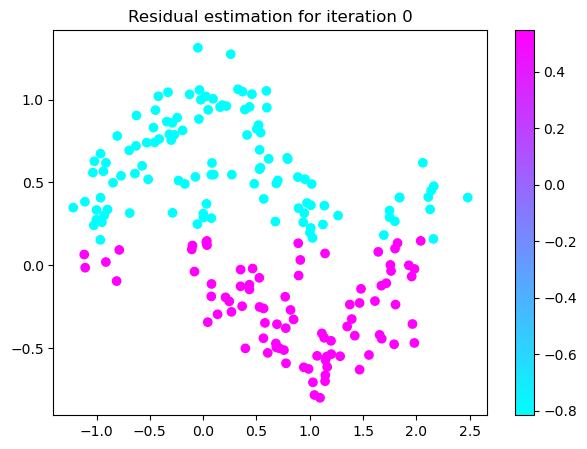

In [239]:
makeiteration(0)
df.head(40)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


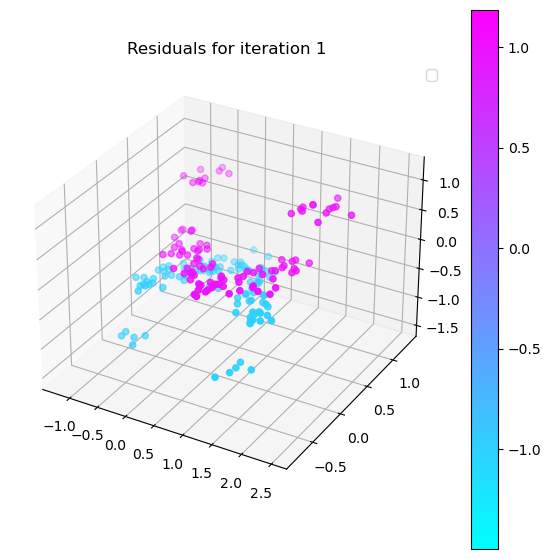

In [240]:
plot_residuals(1)

[Text(0.5, 0.75, 'x1 <= 0.15\nsquared_error = 1.0\nsamples = 200\nvalue = -0.224'),
 Text(0.25, 0.25, 'squared_error = 0.407\nsamples = 87\nvalue = 0.546'),
 Text(0.75, 0.25, 'squared_error = 0.648\nsamples = 113\nvalue = -0.817')]

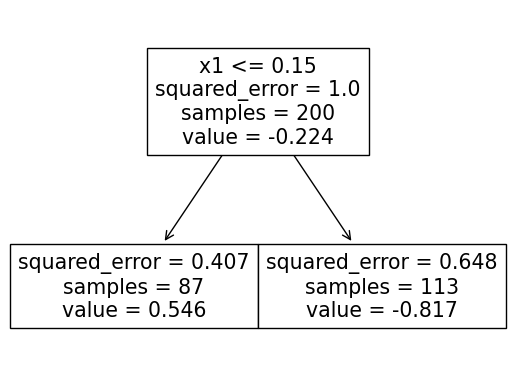

In [241]:

clf = tree.DecisionTreeRegressor(max_depth=1)
clf.fit(X = moon, y = df.r0) #clf := h_0 := arg min_{h in H} \sum L(r_i,h(x_i))
tree.plot_tree(clf, feature_names=['x0','x1'], class_names = [1,-1])



(10000, 2)
[0.5462927836303189, 0.5462927836303189, 0.5462927836303189, 0.5462927836303189, 0.5462927836303189, 0.5462927836303189, 0.5462927836303189, 0.5462927836303189, 0.5462927836303189, 0.5462927836303189]


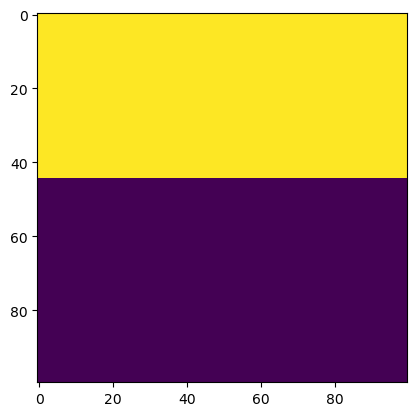

In [242]:
#visualize regression
xmin, xmax = -1.2, 2.3
ymin, ymax = -0.8,1.3
xabs = np.linspace(xmin,xmax, 100)
yabs = np.linspace(ymin,ymax,100)
#cross product xabs x yabs
X,Y = np.meshgrid(xabs,yabs)
#get contours 
XY = product(xabs,yabs)
#Z = clf.predict(product(xabs,yabs))
mat = np.array([*XY])
print(mat.shape)
pred = clf.predict(mat)
fig = plt.figure()
# plt.scatter(moon[:,0], moon[:,1],c=clf.predict(moon))
# plt.contour(X,Y, np.transpose([pred[i:i+100] for i in range(100)]))
print([pred[i*100+i] for i in range(100)][:10])
plt.imshow(np.transpose([pred[i*100:i*100+100] for i in range(100)]))

In [243]:
df.head()

x         y  z        f0        r0     r0hat        f1        r1
0 -0.126891  1.031895 -1  0.223822 -1.223822 -0.816743 -0.184549 -0.815451
1  2.041348  0.147035  1  0.223822  0.776178  0.546293  0.496969  0.503031
2  1.265959  0.299950 -1  0.223822 -1.223822 -0.816743 -0.184549 -0.815451
3  1.791781 -0.477425  1  0.223822  0.776178  0.546293  0.496969  0.503031
4  0.566985 -0.260975  1  0.223822  0.776178  0.546293  0.496969  0.503031

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


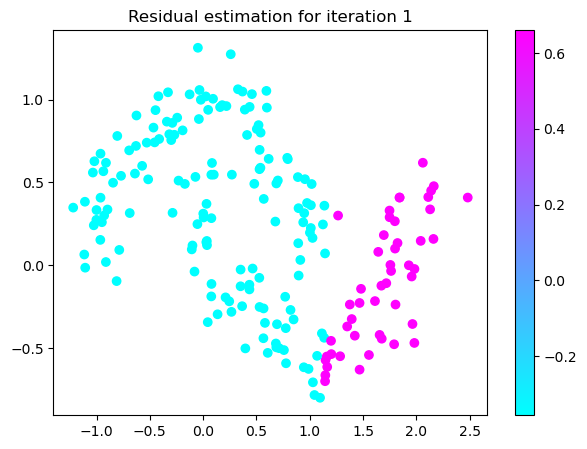

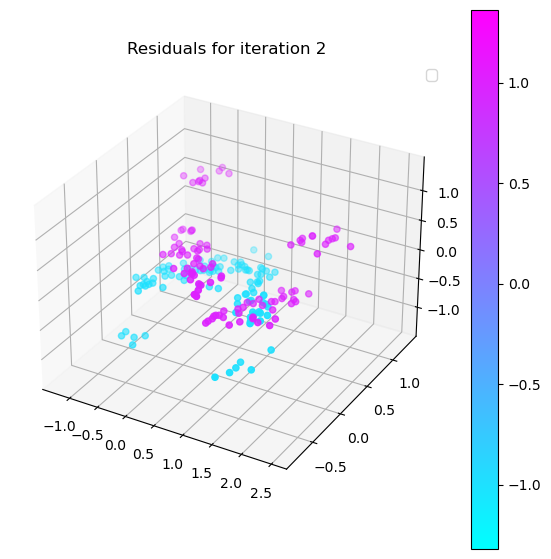

In [244]:
makeiteration(1)
plot_residuals(2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


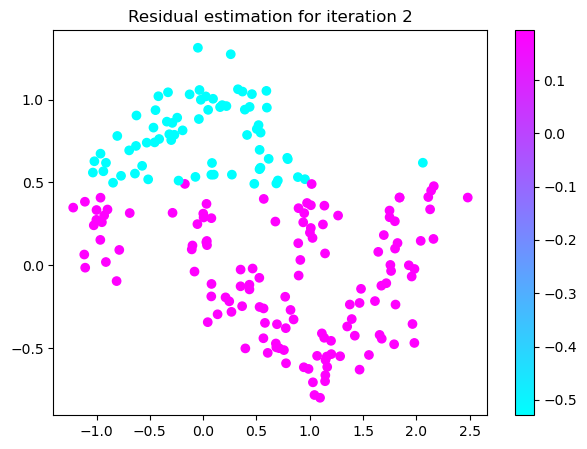

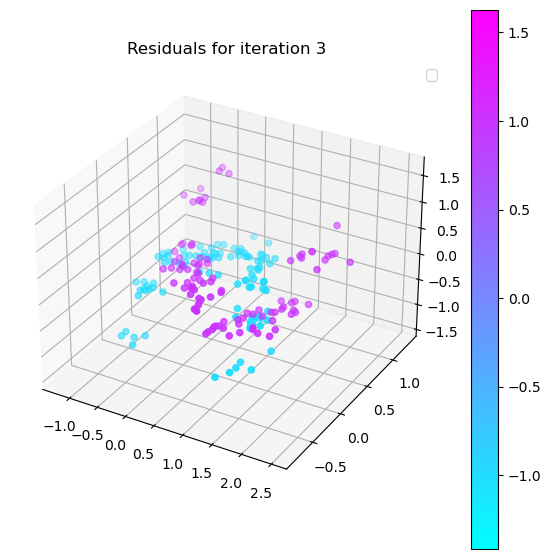

In [245]:
makeiteration(2)
plot_residuals(3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


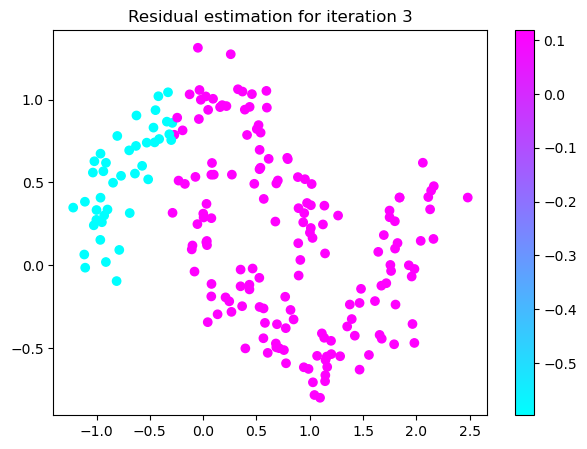

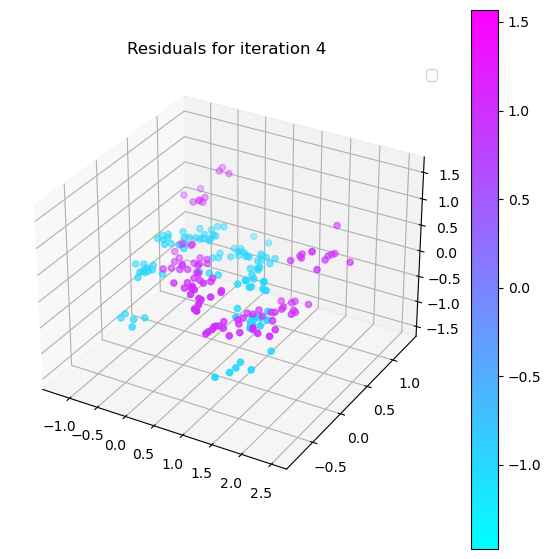

In [246]:
makeiteration(3)
plot_residuals(4)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


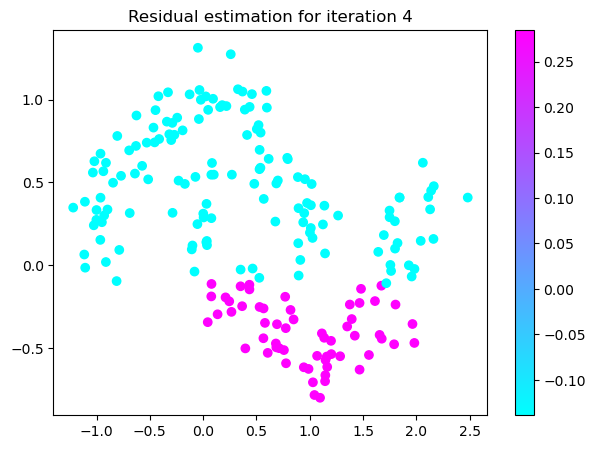

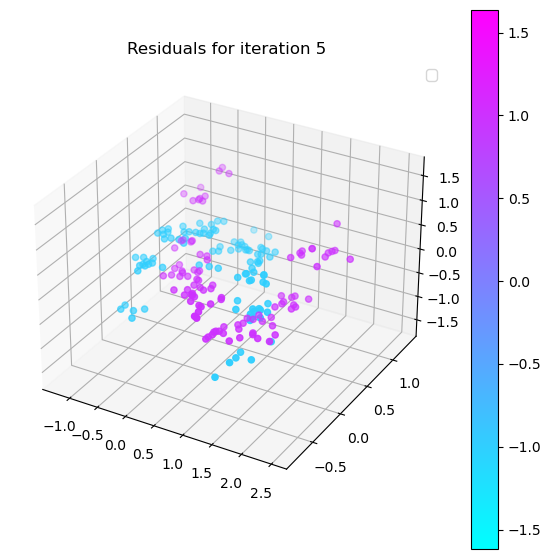

In [247]:
makeiteration(4)
plot_residuals(5)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


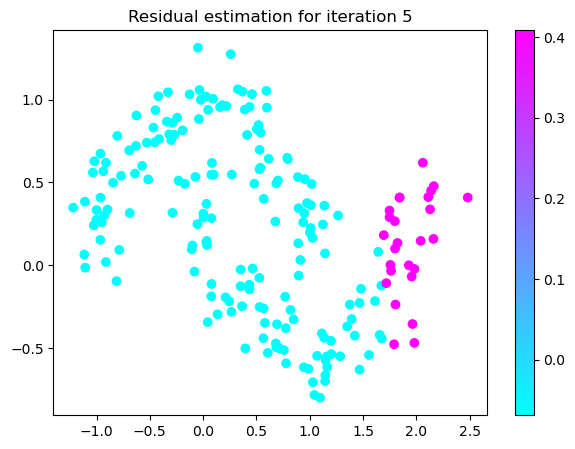

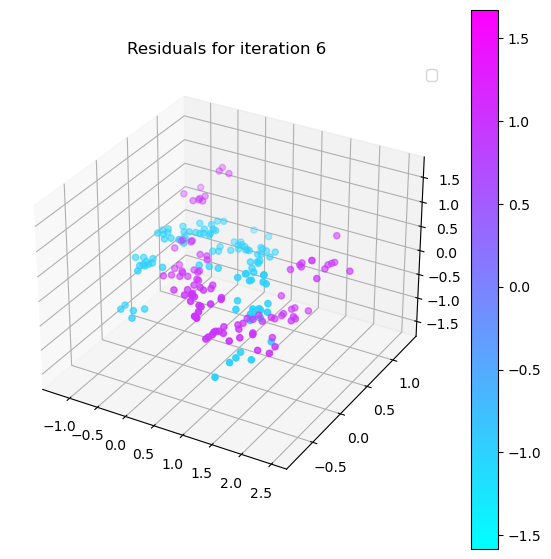

In [248]:
makeiteration(5)
plot_residuals(6)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


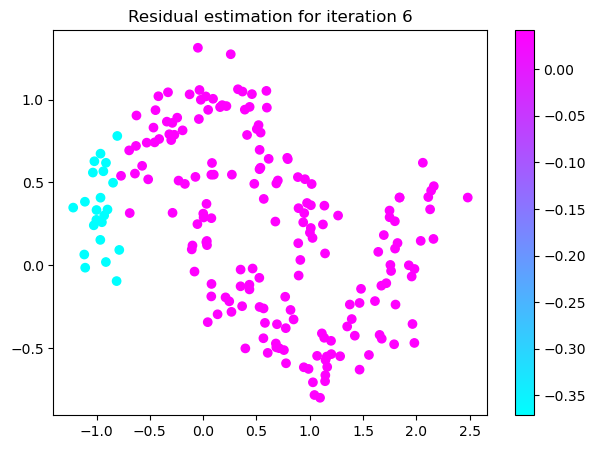

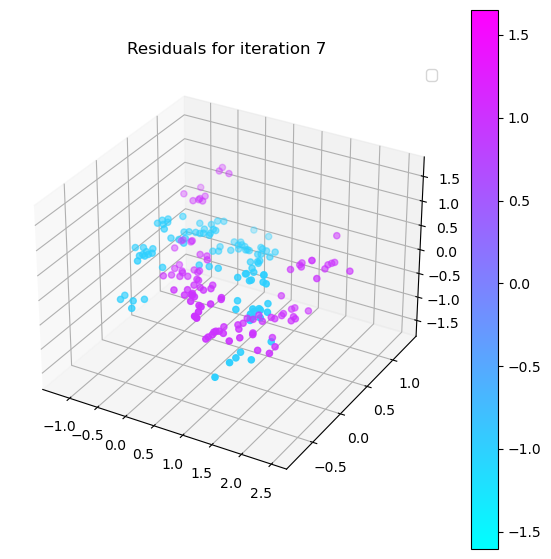

In [249]:
makeiteration(6)
plot_residuals(7)

### Should I draw the correct position with colors corresponding to the residuals? Or correct colors, with position corresponding to residuals?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[-0.8154509   0.50303145  1.1845491  -1.49696855]


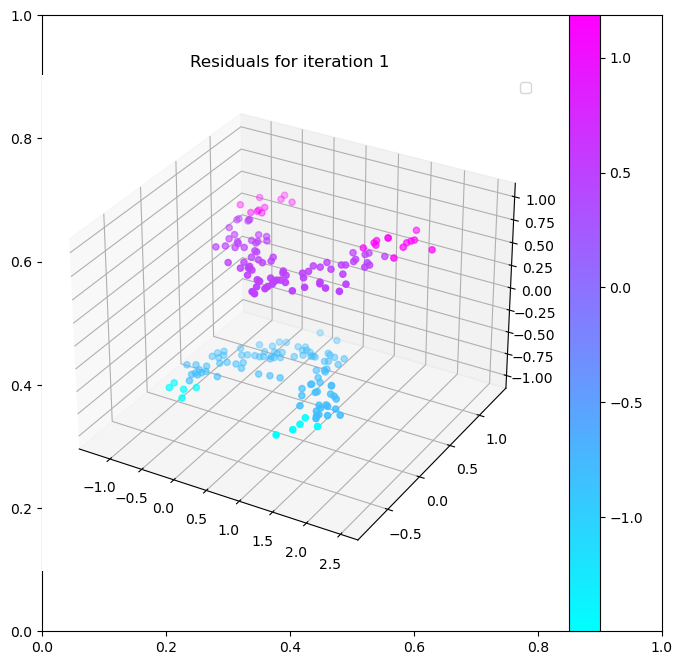

In [168]:

df['r1'] = df['z'] - df['f1']
df.head(20) #remove this later
c1 = df.loc[df.z==1,'r1'].values
c2 = df.loc[df.z==-1,'r1'].values
c_unique = df.loc[:,'r1'].unique()
print(c_unique)



cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=df.loc[:,'r1'].min(), vmax=df.loc[:,'r1'].max())

fig, ax = plt.subplots(figsize=(8, 8))
ax = plt.axes(projection = '3d')
ax.scatter3D(df.loc[df.z == 1,'x'], df.loc[df.z == 1,'y'], 1, c = (c1), marker = 'o', cmap = 'cool', norm = norm )
ax.scatter3D(df.loc[df.z == -1,'x'], df.loc[df.z == -1,'y'], -1, c = (c2), marker = 'o',cmap = 'cool', norm = norm)
ax.legend()
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
ax.set(title=f'Residuals for iteration 1')
ax.legend()




# print(f"Residual values for z = 1 : {df.loc[df.z==1,'r0'].unique()}")
# print(f"Residual values for z = 1 : {df.loc[df.z==-1,'r0'].unique()}")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


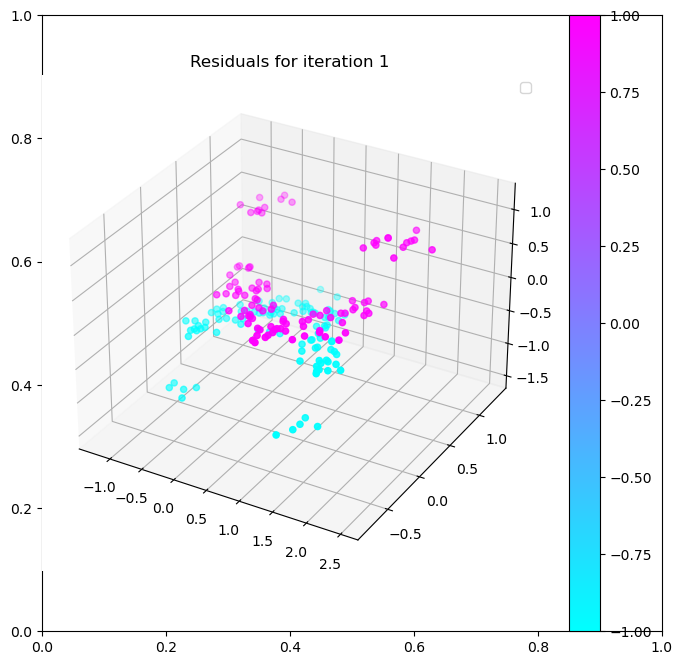

In [169]:

cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=-1, vmax=1)

fig, ax = plt.subplots(figsize=(8, 8))
ax = plt.axes(projection = '3d')
ax.scatter3D(df.loc[df.z==1,'x'], df.loc[df.z==1,'y'], df.loc[df.z==1, 'r1'], c = df.loc[df.z==1, 'z'], marker = 'o', cmap = 'cool', norm = norm )
ax.scatter3D(df.loc[df.z==-1,'x'], df.loc[df.z==-1,'y'], df.loc[df.z==-1, 'r1'], c = df.loc[df.z==-1, 'z'], marker = 'o', cmap = 'cool', norm = norm )
ax.legend()
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
ax.set(title=f'Residuals for iteration 1')
ax.legend()
# Z = np.array([pred[i*100:i*100+100] for i in range(100)]).T
# ax.plot_surface(X,Y,Z, alpha = 0.3)

In [170]:
# # Import dependencies
# import plotly
# import plotly.graph_objs as go

# # Configure Plotly to be rendered inline in the notebook.
# plotly.offline.init_notebook_mode()

# # Configure the trace.
# trace = go.Scatter3d(
#     x=[1, 2, 3],  # <-- Put your data instead
#     y=[4, 5, 6],  # <-- Put your data instead
#     z=[7, 8, 9],  # <-- Put your data instead
#     mode='markers',
#     marker={
#         'size': 10,
#         'opacity': 0.8,
#     }
# )

# # Configure the layout.
# layout = go.Layout(
#     margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
# )

# data = [trace]

# plot_figure = go.Figure(data=data, layout=layout)

# # Render the plot.
# plotly.offline.iplot(plot_figure)

In [171]:
df.head(10)

x         y  z        f0        r0        f1     r0hat        r1
0 -0.126891  1.031895 -1  0.223822 -1.223822 -0.184549 -0.816743 -0.815451
1  2.041348  0.147035  1  0.223822  0.776178  0.496969  0.546293  0.503031
2  1.265959  0.299950 -1  0.223822 -1.223822 -0.184549 -0.816743 -0.815451
3  1.791781 -0.477425  1  0.223822  0.776178  0.496969  0.546293  0.503031
4  0.566985 -0.260975  1  0.223822  0.776178  0.496969  0.546293  0.503031
5  0.369251  1.048691 -1  0.223822 -1.223822 -0.184549 -0.816743 -0.815451
6  0.539335  0.800763 -1  0.223822 -1.223822 -0.184549 -0.816743 -0.815451
7  1.804845 -0.237582  1  0.223822  0.776178  0.496969  0.546293  0.503031
8  0.692728 -0.356325  1  0.223822  0.776178  0.496969  0.546293  0.503031
9 -0.269770  0.787636 -1  0.223822 -1.223822 -0.184549 -0.816743 -0.815451

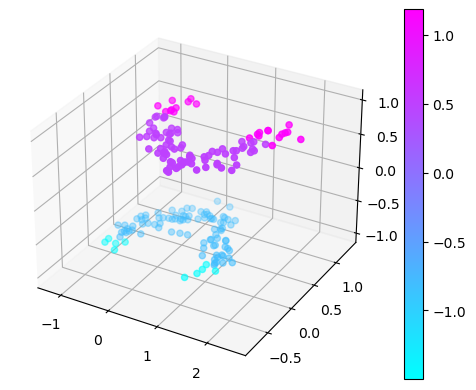

In [173]:
#visualize residuals, ie: 3D graph with points x1,x2 and value z = r1
ax = plt.axes(projection='3d')
scat = ax.scatter3D(df['x'], df['y'], df['z'], c = df['r1'] , cmap = 'cool')
plt.colorbar(scat)

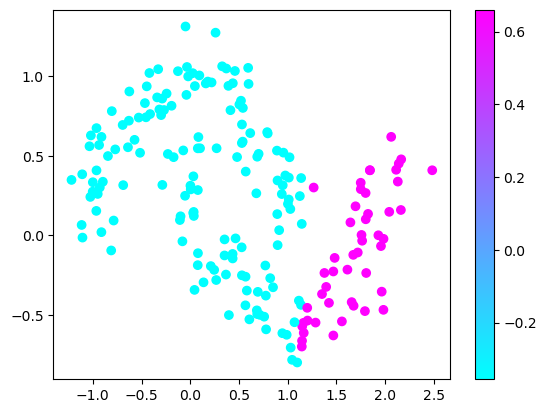

In [177]:
# approximation of residuals with DecisionTree
clf.fit(X=df[['x','y']].values, y = df['r1'])
df['r1hat'] = clf.predict(df[['x','y']].values)

df['f2'] = df.f1 + eta*df['r1hat']
#plot the prediction :
ax = plt.gca()
colors = list('rb')
df2 = df.copy()
# sns.scatterplot(df2[["x1","x2"]].values,x=df2["x1"], y=df2['x2'])
scat = ax.scatter(df['x'], df['y'], c =  df['r1hat'], cmap = 'cool')
plt.colorbar(scat)
# sns.scatterplot(df, x = 'x1' , y = 'x2')
# ax.legend()

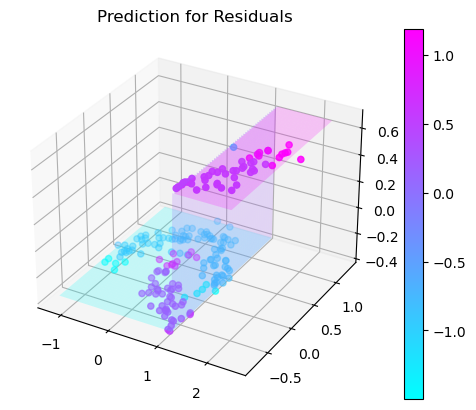

In [180]:
# plot the decision boundary 


#re-use X,Y, XY, and mat for the mesh
pred = clf.predict(mat)
# print([pred[i*100+i] for i in range(100)]) #just printing the diagonal of pred
Z = np.transpose([pred[i*100:i*100+100] for i in range(100)]) 
ax = plt.axes(projection = '3d')
ax.plot_surface(X,Y,Z, cmap = 'cool', alpha = 0.2 )
scat = ax.scatter3D(df['x'], df['y'], df['r1hat'], c =  df['r1'], cmap = 'cool')
ax.set(title = 'Prediction for Residuals')
plt.colorbar(scat)

In [184]:
#add to f1 
df['f2'] = df['f1'] + eta*df['r1hat']
df['r2'] = df['z'] - df['f2']


In [185]:
df.head(20)

x         y  z        f0        r0        f1     r0hat        r1  \
0  -0.126891  1.031895 -1  0.223822 -1.223822 -0.184549 -0.816743 -0.815451   
1   2.041348  0.147035  1  0.223822  0.776178  0.496969  0.546293  0.503031   
2   1.265959  0.299950 -1  0.223822 -1.223822 -0.184549 -0.816743 -0.815451   
3   1.791781 -0.477425  1  0.223822  0.776178  0.496969  0.546293  0.503031   
4   0.566985 -0.260975  1  0.223822  0.776178  0.496969  0.546293  0.503031   
5   0.369251  1.048691 -1  0.223822 -1.223822 -0.184549 -0.816743 -0.815451   
6   0.539335  0.800763 -1  0.223822 -1.223822 -0.184549 -0.816743 -0.815451   
7   1.804845 -0.237582  1  0.223822  0.776178  0.496969  0.546293  0.503031   
8   0.692728 -0.356325  1  0.223822  0.776178  0.496969  0.546293  0.503031   
9  -0.269770  0.787636 -1  0.223822 -1.223822 -0.184549 -0.816743 -0.815451   
10  1.749259  0.289819  1  0.223822  0.776178 -0.184549 -0.816743  1.184549   
11 -0.694056  0.693552 -1  0.223822 -1.223822 -0.184549 -0.816743 -0.815451   
12  1.202677 -0.536850  1  0.223822  0.776178  0.496969  0.546293  0.503031   
13  1.114004 -0.411542  1  0.223822  0.776178  0.496969  0.546293  0.503031   
14 -0.299413  0.755741 -1  0.223822 -1.223822 -0.184549 -0.816743 -0.815451   
15  0.788900  0.648566 -1  0.223822 -1.223822 -0.184549 -0.816743 -0.815451   
16  0.938887  0.258978 -1  0.223822 -1.223822 -0.184549 -0.816743 -0.815451   
17  0.043210 -0.343892  1  0.223822  0.776178  0.496969  0.546293  0.503031   
18  1.956463 -0.068241  1  0.223822  0.776178  0.496969  0.546293  0.503031   
19  1.842520  0.408440  1  0.223822  0.776178 -0.184549 -0.816743  1.184549   

       r1hat        f2        r2  
0  -0.355717 -0.362408 -0.637592  
1   0.660141  0.827039  0.172961  
2   0.660141  0.145521 -1.145521  
3   0.660141  0.827039  0.172961  
4  -0.355717  0.319110  0.680890  
5  -0.355717 -0.362408 -0.637592  
6  -0.355717 -0.362408 -0.637592  
7   0.660141  0.827039  0.172961  
8  -0.355717  0.319110  0.680890  
9  -0.355717 -0.362408 -0.637592  
10  0.660141  0.145521  0.854479  
11 -0.355717 -0.362408 -0.637592  
12  0.660141  0.827039  0.172961  
13 -0.355717  0.319110  0.680890  
14 -0.355717 -0.362408 -0.637592  
15 -0.355717 -0.362408 -0.637592  
16 -0.355717 -0.362408 -0.637592  
17 -0.355717  0.319110  0.680890  
18  0.660141  0.827039  0.172961  
19  0.660141  0.145521  0.854479

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


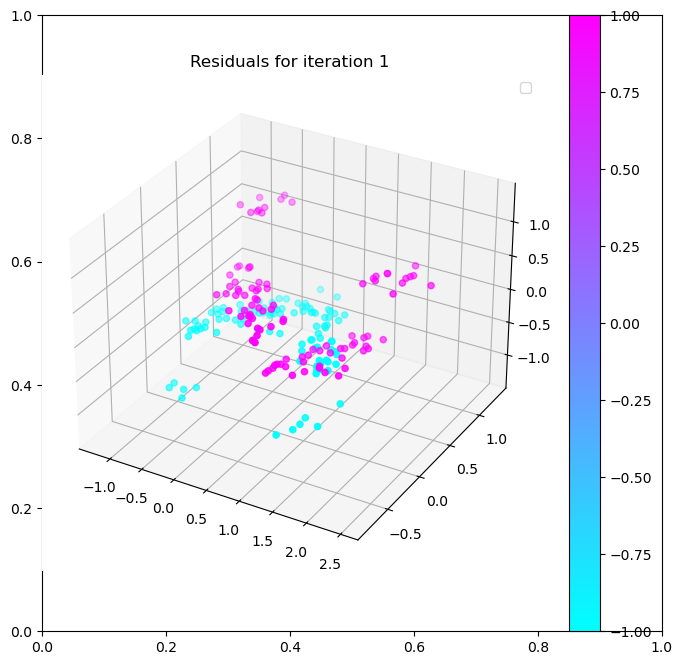

In [186]:
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=-1, vmax=1)

fig, ax = plt.subplots(figsize=(8, 8))
ax = plt.axes(projection = '3d')
ax.scatter3D(df.loc[df.z==1,'x'], df.loc[df.z==1,'y'], df.loc[df.z==1, 'r2'], c = df.loc[df.z==1, 'z'], marker = 'o', cmap = 'cool', norm = norm )
ax.scatter3D(df.loc[df.z==-1,'x'], df.loc[df.z==-1,'y'], df.loc[df.z==-1, 'r2'], c = df.loc[df.z==-1, 'z'], marker = 'o', cmap = 'cool', norm = norm )
ax.legend()
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
ax.set(title=f'Residuals for iteration 2')
ax.legend()

### Iteration 3

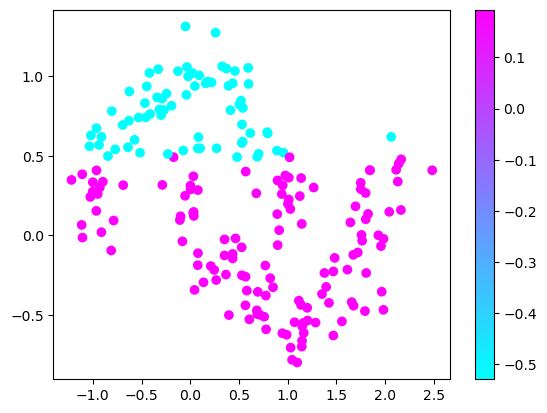

In [196]:
# approximation of residuals with DecisionTree
clf.fit(X=df[['x','y']].values, y = df['r2'])
df['r2hat'] = clf.predict(df[['x','y']].values)

df['f3'] = df.f1 + eta*df['r2hat']
#add to f1 
df['r3'] = df['z'] - df['f3']
#plot the prediction :
ax = plt.gca()
colors = list('rb')
df2 = df.copy()
# sns.scatterplot(df2[["x1","x2"]].values,x=df2["x1"], y=df2['x2'])
scat = ax.scatter(df['x'], df['y'], c =  df['r2hat'], cmap = 'cool')
plt.colorbar(scat)
# sns.scatterplot(df, x = 'x1' , y = 'x2')
# ax.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


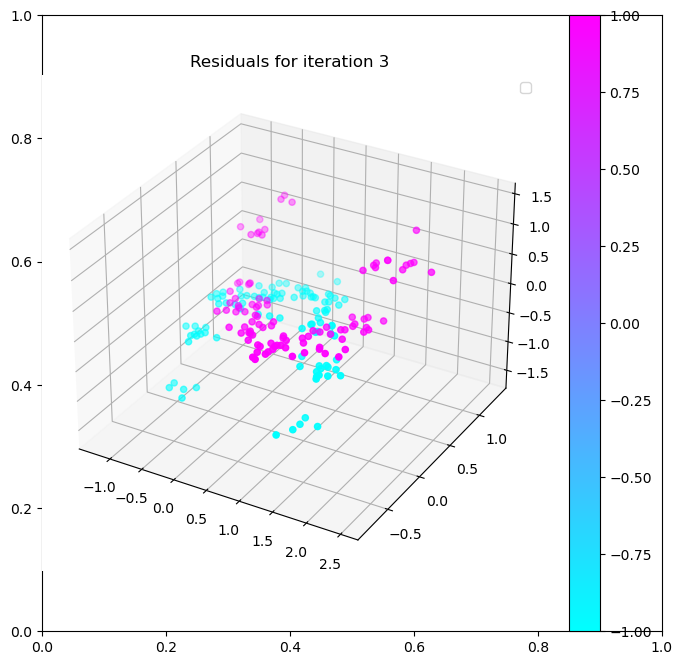

In [204]:
def plot_residuals(i):
    resid = f'r{i}'
    cmap = mpl.cm.cool
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax = plt.axes(projection = '3d')
    ax.scatter3D(df.loc[df.z==1,'x'], df.loc[df.z==1,'y'], df.loc[df.z==1, resid], c = df.loc[df.z==1, 'z'], marker = 'o', cmap = 'cool', norm = norm )
    ax.scatter3D(df.loc[df.z==-1,'x'], df.loc[df.z==-1,'y'], df.loc[df.z==-1, resid], c = df.loc[df.z==-1, 'z'], marker = 'o', cmap = 'cool', norm = norm )
    ax.legend()
    fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    ax.set(title=f'Residuals for iteration {i}')
    ax.legend()
plot_residuals(3)

### Iteration 4

In [198]:
df.head()

x         y  z        f0        r0        f1     r0hat        r1  \
0 -0.126891  1.031895 -1  0.223822 -1.223822 -0.184549 -0.816743 -0.815451   
1  2.041348  0.147035  1  0.223822  0.776178  0.496969  0.546293  0.503031   
2  1.265959  0.299950 -1  0.223822 -1.223822 -0.184549 -0.816743 -0.815451   
3  1.791781 -0.477425  1  0.223822  0.776178  0.496969  0.546293  0.503031   
4  0.566985 -0.260975  1  0.223822  0.776178  0.496969  0.546293  0.503031   

      r1hat        f2        r2     r2hat        f3        r3     r3hat  \
0 -0.355717 -0.362408 -0.637592 -0.529012 -0.449055 -0.550945 -0.290773   
1  0.660141  0.827039  0.172961  0.193211  0.593574  0.406426  0.571058   
2  0.660141  0.145521 -1.145521  0.193211 -0.087943 -0.912057  0.571058   
3  0.660141  0.827039  0.172961  0.193211  0.593574  0.406426  0.571058   
4 -0.355717  0.319110  0.680890  0.193211  0.593574  0.406426 -0.290773   

         f4        r4     r4hat        f5        r5  
0 -0.329935 -0.550945 -0.290773 -0.329935 -0.670065  
1  0.782498  0.406426  0.571058  0.782498  0.217502  
2  0.100980 -0.912057  0.571058  0.100980 -1.100980  
3  0.782498  0.406426  0.571058  0.782498  0.217502  
4  0.351582  0.406426 -0.290773  0.351582  0.648418

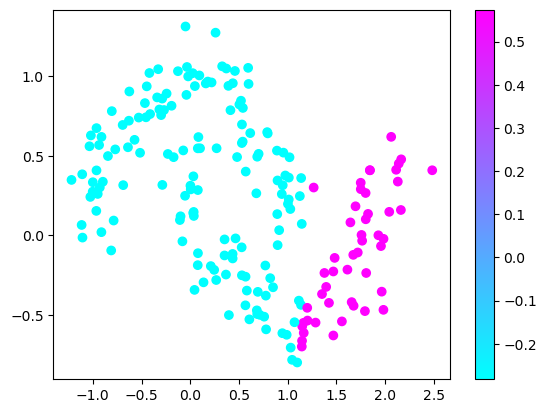

In [206]:
# approximation of residuals with DecisionTree
def makeiteration(i:int):
    """Takes the dataframe ith f_i and r_i and approximated r_i from the features, then computes f_i+1 and r_i+1"""
    clf.fit(X=df[['x','y']].values, y = df[f'r{i}'])
    df[f'r{i}hat'] = clf.predict(df[['x','y']].values)

    df[f'f{i+1}'] = df.f1 + eta*df[f'r{i}hat']
    #add to f1 
    df[f'r{i+1}'] = df['z'] - df[f'f{i}']
    #plot the prediction :
    ax = plt.gca()
    colors = list('rb')
    df2 = df.copy()
    # sns.scatterplot(df2[["x1","x2"]].values,x=df2["x1"], y=df2['x2'])
    scat = ax.scatter(df['x'], df['y'], c =  df[f'r{i}hat'], cmap = 'cool')
    plt.colorbar(scat)
    # sns.scatterplot(df, x = 'x1' , y = 'x2')
    # ax.legend()
makeiteration(7)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


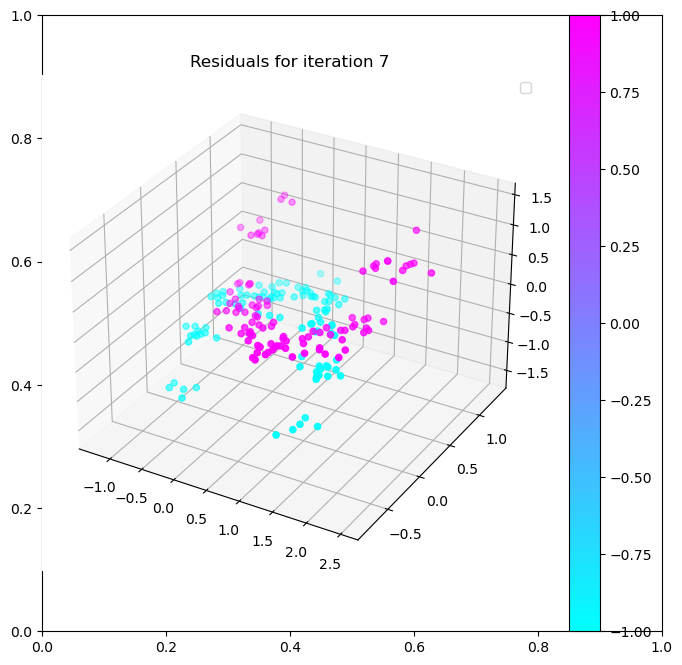

In [207]:
plot_residuals(7)